#  Song Lyric Analysis and Pre-processing

In this notebook, we will perform exploratory data analysis on our song lyric dataset. We will also process our lyric text using various tools from the NLTK library. All data cleaning and pre-processing steps are also in the `preprocess.py` script.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [4]:
data = pd.read_csv("data/lyrics.csv")
print("Number of songs: {:d}".format(data.shape[0]))

Number of songs: 362237


## Step 1: Exploratory Data Analysis

In [5]:
data.head(1)

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."


#### Missing Values

In [6]:
data.isnull().sum()

index         0
song          2
year          0
artist        0
genre         0
lyrics    95680
dtype: int64

There are 95680 songs that have missing lyrics. Let's drop all rows with missing values.

In [7]:
data = data.dropna()

### Which genre is the most popular?

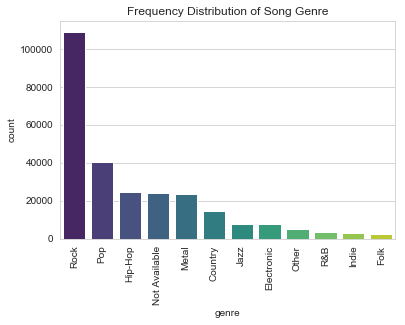

In [8]:
genres = data['genre'].value_counts().reset_index()
genres.columns = ['genre', 'count']

sns.set_style("whitegrid")
sns.barplot(x='genre', y='count', data=genres, palette='viridis')
plt.xticks(rotation=90)
plt.title('Frequency Distribution of Song Genre')
plt.show()

In [9]:
print("The most popular genre is {:s}, followed by {:s}.".format(genres['genre'][0], genres['genre'][1]))
print("The least popular genre is {:s}.".format(genres["genre"].iloc[-1]))

The most popular genre is Rock, followed by Pop.
The least popular genre is Folk.


### Which artist has the most songs?

Mean number of songs per artist: 18.33.
Median number of songs per artist: 4.00.


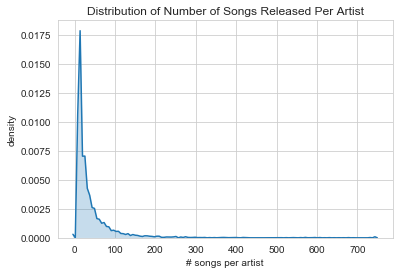

In [10]:
artists = data['artist'].value_counts().reset_index()
artists.columns = ['artist', 'count']

print("Mean number of songs per artist: {:.2f}.".format(artists['count'].mean()))
print("Median number of songs per artist: {:.2f}.".format(artists['count'].median()))


sns.kdeplot(artists['count'], shade=True, legend=False)
plt.xlabel('# songs per artist')
plt.ylabel('density')
plt.title('Distribution of Number of Songs Released Per Artist')
plt.show()

In [11]:
print("The artist with the most songs in this dataset is {:s}.".format(artists['artist'][0]))

The artist with the most songs in this dataset is dolly-parton.


### When are songs most frequently released?

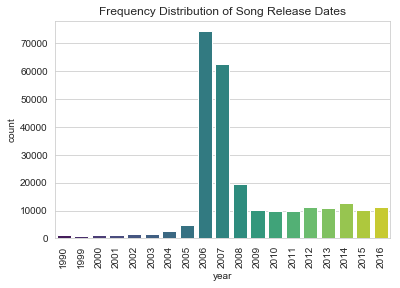

In [12]:
years = data['year'].value_counts().reset_index()
years.columns = ['year', 'count']

# filter out years that have count less than 1000
years = years[years['count'] > 1000]
sns.barplot(x='year', y='count', data=years, palette='viridis')
plt.xticks(rotation=90)
plt.title("Frequency Distribution of Song Release Dates")
plt.show()

This dataset has the most songs released in 2006.

## Step 2: Pre-processing Song Lyrics

In [13]:
pd.options.mode.chained_assignment = None

hiphop = data[data['genre'] == 'Hip-Hop']

#### Tokenizing words

Our lyrics need to be tokenized in order to properly analyze their content. Tokenization is the process of breaking up a string into smaller pieces. In this particular example, we will be breaking up a song's lyrics into a string of words. We will also remove stopwords using NLTK's stopwords library, and words that have less than 3 characters. 

In [27]:
def tokenize_lyrics(x):
    custom_stopwords = ["'s", "n't", "'m", "'re", "'ll","'ve","...", "ä±", "''", '``','--', "'d", 'el', 'la', "let"]
    stopwords = nltk.corpus.stopwords.words('english') + custom_stopwords
    tokens = nltk.word_tokenize(x.lower())
    tokens = [t.strip('-./') for t in tokens]
    tokenized = [t for t in tokens if len(t) > 2 and t.isalpha() and t not in stopwords]
    return tokenized

In [15]:
hiphop['tokenized_lyrics'] = hiphop['lyrics'].apply(tokenize_lyrics)
hiphop['word_count'] = hiphop['tokenized_lyrics'].apply(len)

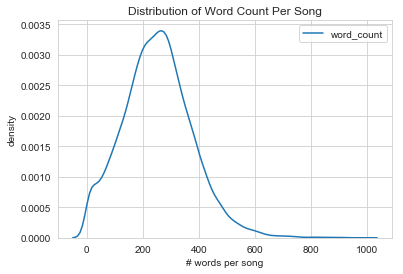

In [16]:
# filter out songs that have more than 1000 words
hiphop_filtered = hiphop[hiphop['word_count'] < 1000]

sns.kdeplot(hiphop_filtered['word_count'])
plt.xlabel("# words per song")
plt.ylabel("density")
plt.title("Distribution of Word Count Per Song")
plt.show()

#### Stemming and Lemmatization

After tokenizing the lyrics and filtering out stopwords, our next step is to perform stemming and/or lemmatization. These two techniques work by grouping inflected words to a common base form. For example, `organize`, `organizes`, and `organizing` are different forms of the same meaning and could be grouped into the same category. 
Stemming is a crude process that simply chops off ends of words in attempt to identify a word's root. Lemmatization is a more complex technique that performs a morphological analysis on words in attempt to identify its "lemma" (or proper root).

In this particular example, we will be using lemmatization to group our inflected words. We will use NLTK's WordNetLemmatizer class.

**Warning: the WordNetLemmatizer code below takes a while to run**

In [17]:
from nltk.stem import WordNetLemmatizer

def lemmatize(tokens):
    lemmatized = [WordNetLemmatizer().lemmatize(t) for t in tokens]
    return lemmatized

hiphop['tokenized_lyrics'] = hiphop['tokenized_lyrics'].apply(lemmatize)

Now that we have our tokenized and lemmatized lyrics, let's see which words are most common in our `hiphop` lyric dataset.

In [18]:
from collections import Counter

word_freq = Counter(w for words in hiphop['tokenized_lyrics'] for w in words)
print("Top 10 most common words are:", word_freq.most_common(10))

Top 10 most common words are: [('like', 99393), ('got', 83589), ('get', 77341), ('nigga', 73893), ('know', 63749), ('shit', 37514), ('see', 34489), ('yeah', 33059), ('love', 32837), ('bitch', 32085)]


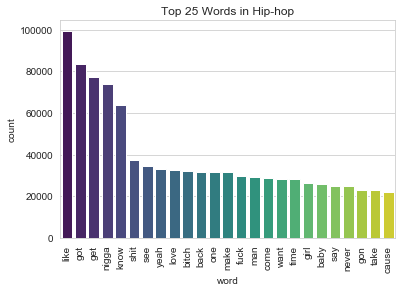

In [35]:
top_n = 25
common_words = pd.DataFrame(word_freq.most_common(top_n), columns=['word', 'count'])

sns.barplot(x='word', y='count', data=common_words, palette="viridis")
plt.title("Top {:d} Words in Hip-hop".format(top_n))
plt.xticks(rotation=90)
plt.show()

## Step 3: More pre-processing with TF-IDF

Before we can start topic modelling, we must apply term frequency-inverse document frequency (TFIDF) vectorization to our tokenized dataset. TFIDF is used to determine how important a word is to a document in a collection or corpus ([ref](https://www.wikiwand.com/en/Tf%E2%80%93idf)). For example, let's say the word "like" is very popular across all songs. Using TFIDF, we downweight the importance of "like" because it is a word that occurs frequently within our corpus. Let's say "democracy" is another word within that song but it is very rare across all songs. Its importance would be upweighted using TFDIF because it doesn't occur very often in our corpus.

Note: scikit-learn's `TfidfVectorizer` expects an array of strings. So, we will need to concatenate our tokenized words together as a string for TFIDF to work properly. That being said, our concatenated tokenized words are very different from our original lyrics because we filtered out stopwords and performed lemmatization.

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer

hiphop['processed_lyrics'] = hiphop['tokenized_lyrics'].apply(lambda x: ' '.join(x))

tfidf = TfidfVectorizer()
X_hiphop = tfidf.fit_transform(hiphop['processed_lyrics'])

In [58]:
X_hiphop.shape

(24850, 150196)

In [59]:
X_hiphop

<24850x150196 sparse matrix of type '<class 'numpy.float64'>'
	with 3780803 stored elements in Compressed Sparse Row format>

Now that we have a TFIDF matrix, we can start topic modeling with Latent Dirichlet Allocation (LDA) and Non-zero Matrix Factorization (NMF). See `lyrics-modeling.ipynb` notebook for topic modeling results. 